# Artificial Neural Networks and Deep Learning

---

## Homework 2: U-Net


## ⚙️ Import Libraries

In [105]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [106]:
data = np.load("/kaggle/input/cleans/clean_dataset.npz")

X_train = data["images"]
y_train = data["labels"]
X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [107]:
# Splitting the dataset 80/20 (training and validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

#Display the resulting shapes
print(f"Training images shape: {X_train.shape}, Validation images shape: {X_val.shape}")
print(f"Training masks shape: {y_train.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2004, 64, 128), Validation images shape: (501, 64, 128)
Training masks shape: (2004, 64, 128), Validation masks shape: (501, 64, 128)


In [108]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")

X_train shape: (2004, 64, 128, 1)
y_train shape: (2004, 64, 128)
X_test shape: (10022, 64, 128, 1)
Number of classes: 5


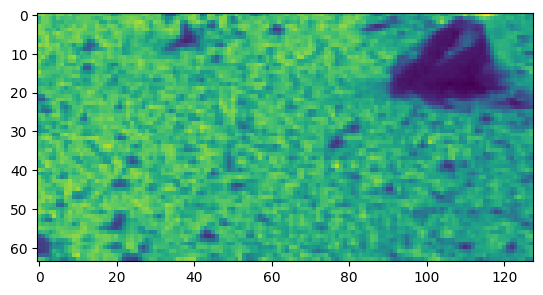

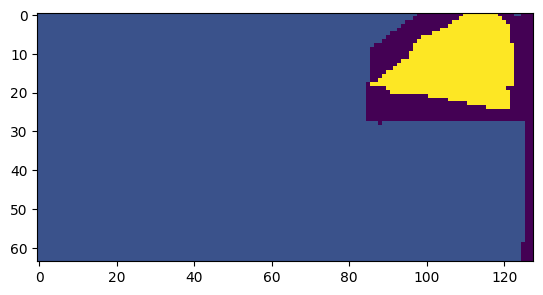

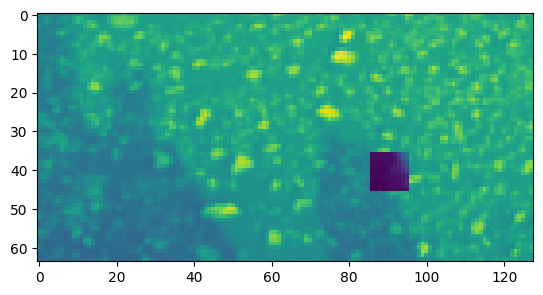

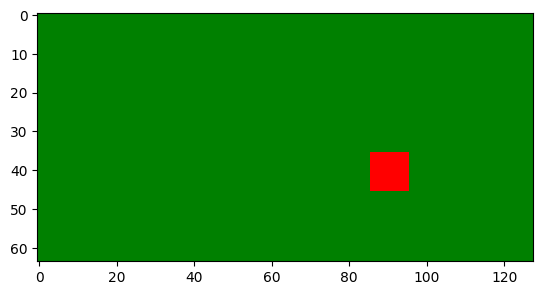

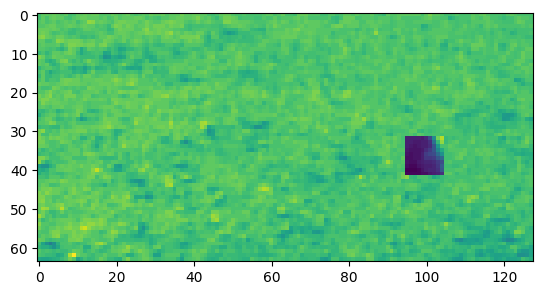

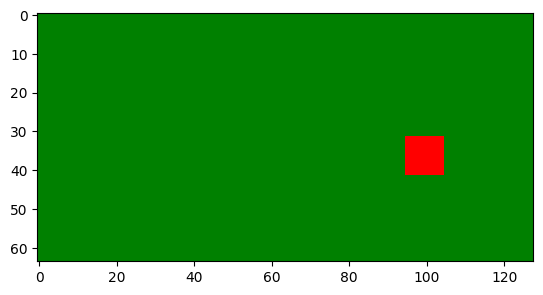

In [109]:
def cut_big_rock(X,y,alpha=1.0):
    i=479
    plt.imshow(X_train[i])
    
    plt.show()
    plt.imshow(y_train[i])
    plt.show()

    batch_size, height, width, channel = X.shape  # No channel dimension for grayscale
    # Generate CutMix lambda
    lam = np.random.beta(alpha, alpha)
    cut_rat = np.sqrt(1.0 - lam)  # Cutout ratio
    cut_h = int(height * cut_rat)
    cut_w = int(width * cut_rat)
    
    # Randomly choose cutout position

    x1,x2= 110,120
    y1,y2=10,20
    
    # Apply CutMix
    X_cut = X.copy()
    y_cut = y.copy()
    # print(len(y_cut))
    # half_index_x= len(X_cut) // 2
    # half_index_y= len(y_cut) // 2  # Calcola il punto di metà
    # X_cut = X_cut[:half_index_x]
    # y_cut = y_cut[:half_index_y] 
    # print(len(y_cut))
    

    for ind in range(len(X_cut)):
        cx = np.random.randint(0, width-10)
        cy = np.random.randint(0, height-10)
        rx1 = np.clip(cx, 0, width)
        rx2 = rx1+10
        ry1 = np.clip(cy, 0, height)
        ry2 = ry1+10
        X_cut[ind, ry1:ry2, rx1:rx2] = X[i, y1:y2, x1:x2]
        y_cut[ind, ry1:ry2, rx1:rx2] = y[i, y1:y2, x1:x2]
        
    return X_cut, y_cut

X_cut_r, y_cut_r = cut_big_rock(X_train, y_train)


from matplotlib.colors import ListedColormap
cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])

vmin, vmax = 0, 4

for i in range(122,124):
    plt.imshow(X_cut_r[i])
    plt.show()
    plt.imshow(y_cut_r[i],cmap=cmap, vmin=vmin, vmax=vmax)
    plt.show()

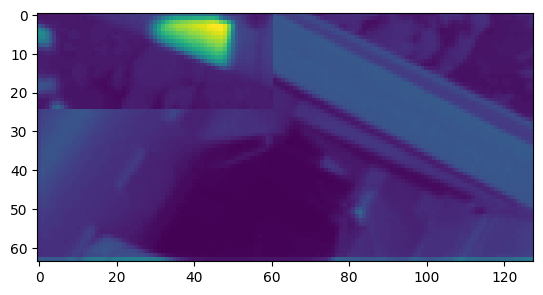

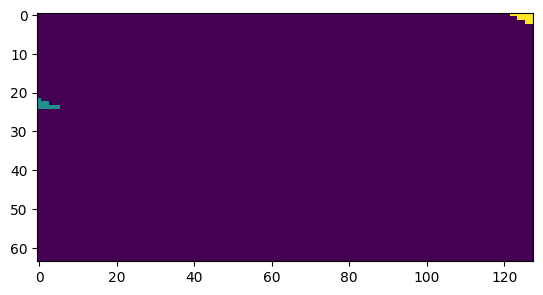

In [110]:
#cutmix
# Try to balance the dataset
# Custom CutMix implementation
def cutmix_images_and_masks(X, y,alpha=1.0):
    
    batch_size, height, width, channel = X.shape  # No channel dimension for grayscale
    indices = np.random.permutation(batch_size)
    
    # Generate CutMix lambda
    lam = np.random.beta(alpha, alpha)
    cut_rat = np.sqrt(1.0 - lam)  # Cutout ratio
    cut_h = int(height * cut_rat)
    cut_w = int(width * cut_rat)
    
    # Randomly choose cutout position
    cx = np.random.randint(0, width)
    cy = np.random.randint(0, height)
    
    # Define box coordinates
    x1 = np.clip(cx - cut_w // 2, 0, width)
    x2 = np.clip(cx + cut_w // 2, 0, width)
    y1 = np.clip(cy - cut_h // 2, 0, height)
    y2 = np.clip(cy + cut_h // 2, 0, height)
    
    # Apply CutMix
    X_cut = X.copy()
    y_cut = y.copy()
    X_cut[:, y1:y2, x1:x2] = X[indices, y1:y2, x1:x2]
    y_cut[:, y1:y2, x1:x2] = y[indices, y1:y2, x1:x2]
    
    return X_cut, y_cut

X_cut, y_cut = cutmix_images_and_masks(X_train, y_train)

# X_train = np.concatenate((X_train,X_cut),axis=0)
# y_train = np.concatenate((y_train,y_cut),axis=0)
# X_train = np.concatenate((X_train,X_cut_r),axis=0)
# y_train = np.concatenate((y_train,y_cut_r),axis=0)
plt.imshow(X_cut[120])
plt.show()
plt.imshow(y_cut[120])
plt.show()

In [111]:
# i = 0
# count = 0
# array = []

# from matplotlib.colors import ListedColormap
# cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])

# # Valori per la mappa
# vmin, vmax = 0, 4
# for mask in y_train:
#     found = False
#     for (row, x) in zip(mask, range(len(mask))):
#         for (column, y) in zip(row, range(len(row))):
#             if np.isclose(column, 4.0) and found == False:
#                 count += 1
#                 array.append(i)
#                 print(i)
#                 plt.imshow(X_train[i])
#                 plt.title(f"{x=}, {y=}")
#                 plt.show()
#                 plt.imshow(mask, cmap=cmap, vmin=vmin, vmax=vmax)
#                 plt.show()
                
#                 found = True            
#     i += 1

# print(count)
# print(array)

#457

In [112]:
# for i in big_rock_indices:
#     print(i)
#     plt.imshow(X_train[i])
#     plt.axis('off')
#     plt.show()

#     plt.imshow(y_train[i])
#     plt.axis('off')
#     plt.show()

## 🛠️ Train and Save the Model

In [113]:
# Define hyperparameters
epochs = 200
batch_size = 64

In [114]:
# Define callbacks
# Early stopping to stop the training when val_accuracy stop to increase
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True,
    start_from_epoch=50
)

# Reduce LR when val_loss stop to decrease to avoid local minumum
reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=20
)

callbacks = [early_stopping, reduce_lr_on_plateau]

In [115]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Apply a sequence of Conv2D, Batch Normalization, and Activation layers for the specified number of stacks
    x = input_tensor
    for i in range(stack):
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    # Return the final output tensor with the residual connection
    return x

In [116]:
def res_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Apply a sequence of Conv2D, Batch Normalization, and Activation layers for the specified number of stacks
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    # Return the final output tensor with the residual connection
    res =tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'convres')(input_tensor)
    res = tfkl.BatchNormalization(name=name + 'bnres')(res)
    res = tfkl.Activation(activation, name=name + 'activationres')(res)
    x = tfkl.Add()([res,x])
    return x

In [117]:
def ASPP(x, filter):
    shape = x.shape

    y1 = tfkl.AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = tfkl.Conv2D(filter, 1, padding="same")(y1)
    y1 = tfkl.BatchNormalization()(y1)
    y1 = tfkl.Activation("relu")(y1)
    y1 = tfkl.UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = tfkl.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = tfkl.BatchNormalization()(y2)
    y2 = tfkl.Activation("relu")(y2)

    y3 = tfkl.Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = tfkl.BatchNormalization()(y3)
    y3 = tfkl.Activation("relu")(y3)

    y4 = tfkl.Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = tfkl.BatchNormalization()(y4)
    y4 = tfkl.Activation("relu")(y4)

    y5 = tfkl.Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = tfkl.BatchNormalization()(y5)
    y5 = tfkl.Activation("relu")(y5)

    y = tfkl.Concatenate()([y1, y2, y3, y4, y5])

    y = tfkl.Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = tfkl.BatchNormalization()(y)
    y = tfkl.Activation("relu")(y)

    return y

In [118]:
def se_block(in_block, ch, ratio=16):
    # Squeeze: Global Average Pooling converts each channel to a single numerical value
    y = tfkl.GlobalAveragePooling2D()(in_block)
    
    # Excitation: Two Dense blocks transform the n values to n weights for each channel
    y = tfkl.Dense(ch // ratio, activation='relu')(y)  # The first layer with a ReLU activation
    y = tfkl.Dense(ch, activation='sigmoid')(y)        # The second (last) layer with a sigmoid activation (acting as a smooth gating function)
    
    # Scale and Combine: Apply weights to the channels by element-wise multiplication
    return tfkl.Multiply()([in_block, y])

In [119]:
def expend_as(tensor, rep):

    #!!!!!!!!!!!!!! QUESTO LAMBDA LAYER NON PUO' VENIRE SALVATO NELLA SUBMISSION NON SO PERCHE'
    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2
    output_shape=tfk.backend.int_shape(tensor)
    output_shape=(output_shape[1],output_shape[2],output_shape[3])
    my_repeat = tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},
                      output_shape=output_shape)(tensor)
    return my_repeat

In [120]:
def AttnGatingBlock(x, g, inter_shape):

    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(g)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(filters=inter_shape, kernel_size=1, strides=1, padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(filters=inter_shape, kernel_size=3, strides=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]), padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = tfkl.Add()([phi_g, theta_x])
    add_xg = tfkl.Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = tfkl.Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = psi.shape

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, shape_x[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = tfkl.Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = tfkl.Conv2D(filters=shape_x[3], kernel_size=1, strides=1, padding='same')(attn_coefficients)
    #output = tfkl.BatchNormalization()(output)
    return output

In [121]:
def complex_net(input_shape=(64, 128, 3), num_classes=num_classes, seed=seed):
    #Following https://arxiv.org/pdf/2305.07850
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    n=64
    down_block_1 = tfkl.Conv2D(filters=n, kernel_size=1, strides=1, padding='same')(input_layer)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = tfkl.Conv2D(filters=n*2, kernel_size=1, strides=1, padding='same')(d1)
    down_block_2 = se_block(down_block_2,n*2)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = tfkl.Conv2D(filters=n*4, kernel_size=1, strides=1, padding='same')(d2)
    down_block_3 = se_block(down_block_3,n*4)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = tfkl.Conv2D(filters=n*8, kernel_size=1, strides=1, padding='same')(d3)
    d4 = tfkl.MaxPooling2D()(down_block_4)

    bn = tfkl.Conv2D(filters=n*16, kernel_size=1, strides=1, padding='same')(d4)

    up4 = AttnGatingBlock(down_block_4,bn,n*8)
    up4 = tfkl.Conv2D(filters=n*8, kernel_size=1, strides=1, padding='same')(up4)

    up3 = AttnGatingBlock(down_block_3,up4,n*4)
    up3 = tfkl.Conv2D(filters=n*4, kernel_size=1, strides=1, padding='same')(up3)

    up2 = AttnGatingBlock(down_block_2,up3,n*2)
    up2 = tfkl.Conv2D(filters=n*2, kernel_size=1, strides=1, padding='same')(up2)

    up1 = AttnGatingBlock(down_block_1,up2,n)
    up1 = tfkl.Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='same')(up1)
    
    model = tf.keras.Model(inputs=input_layer, outputs=up1, name='UNet')
    return model

In [122]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    n=64
    down_block_1 = res_block(input_layer, n, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)
    
    down_block_2 = res_block(d1, n*2, name='down_block2_')
    down_block_2 = se_block(down_block_2,n*2)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = res_block(d2, n*4, name='down_block3_')
    down_block_3 = se_block(down_block_3,n*4)
    down_block_3 = tfkl.Dropout(0.5)(down_block_3)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = res_block(d3, n*8, name='bottleneck')
    #bottleneck=ASPP(d3,n*8)
    bottleneck = tfkl.Dropout(0.5)(bottleneck)

    # u3 = tfkl.UpSampling2D()(bottleneck)
    # u3 = tfkl.Concatenate()([u3, down_block_3])
    u3= AttnGatingBlock(down_block_3,bottleneck,n*4)
    u3 = res_block(u3, n*4, name='up_block3_')

    # u2 = tfkl.UpSampling2D()(u3)
    # u2 = tfkl.Concatenate()([u2, down_block_2])
    u2= AttnGatingBlock(down_block_2,u3,n*2)
    u2 = res_block(u2, n*2, name='up_block2_')

    
    # u1 = tfkl.UpSampling2D()(u2)
    # u1 = tfkl.Concatenate()([u1, down_block_1])
    u1= AttnGatingBlock(down_block_1,u2,n)
    u1 = res_block(u1, n, name='up_block1_')
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [123]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tfk.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [124]:
def generalized_dice_loss(y_true, y_pred):
    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # Compute per-class weights
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(0, 1, 2))
    weights = 1 / (tf.reduce_sum(y_true, axis=(0, 1, 2)) ** 2 + 1e-6)
    
    # Generalized Dice Score
    dice_score = tf.reduce_sum(weights * numerator) / tf.reduce_sum(weights * denominator)
    
    # Loss is 1 - Dice Score
    return 1 - dice_score

def combined_loss(y_true, y_pred):
    return ensemble_loss(y_true, y_pred)

def ensemble_loss(y_true, y_pred, num_classes=5, alpha=0.5, beta=0.5, gamma=0):
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    # Exclude the background class (label 0)
    y_true_one_hot = y_true_one_hot[..., 1:]  # Ignore background in ground truth
    y_pred = y_pred[..., 1:]  # Ignore background in predictions

    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # 1. Dice Loss
    class_weights = 1 / (tf.reduce_sum(y_true_one_hot, axis=(0, 1, 2)) + 1e-6)
    numerator = 2 * tf.reduce_sum(y_true_one_hot * y_pred, axis=(0, 1, 2))
    denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=(0, 1, 2))
    dice_loss = 1 - tf.reduce_sum(class_weights * numerator) / tf.reduce_sum(class_weights * denominator)
    
    # 2. Focal Loss
    gamma_focal = 2.0
    focal_loss = -tf.reduce_mean(
        tf.reduce_sum(
            y_true_one_hot * ((1 - y_pred) ** gamma_focal) * tf.math.log(y_pred), axis=-1
        )
    )
    
    #3. Boundary loss
    def erosion2d_custom(tensor, d=1):
            kernel = tf.ones((d, d, tensor.shape[-1]), dtype=tf.float32)  # Create kernel
            kernel = tf.expand_dims(kernel, axis=-1)  # [d, d, channels, 1]
            eroded = tf.nn.depthwise_conv2d(
                input=tensor,
                filter=kernel,
                strides=[1, 1, 1, 1],
                padding="SAME"
            )
            return tf.cast(eroded == tf.reduce_sum(kernel), dtype=tf.float32)
    def boundary_dou_loss(y_true, y_pred, d=1):
        

        # Ensure predictions are between 0 and 1
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        
        # Create the boundary mask
        kernel = tf.ones((d, d, 4), dtype=tf.float32)

        y_true_eroded = erosion2d_custom(y_true)
        y_pred_eroded= erosion2d_custom(y_pred)
        # Erode ground truth and predictions to find the inner boundary
        # y_true_eroded = tf.nn.erosion2d(
        #     #tf.expand_dims(y_true,-1),  # Add channel dimension
        #     y_true,
        #     filters=kernel,
        #     strides=[1, 1, 1, 1],
        #     dilations=[1,1,1,1],
        #     padding="SAME",
        #     data_format="NHWC"
        # )#[..., 0]  # Remove channel dimension

        # y_pred_eroded = tf.nn.erosion2d(
        #     #tf.expand_dims(y_pred,-1),
        #     y_pred,
        #     filters=kernel,
        #     strides=[1, 1, 1, 1],
        #     dilations=[1,1,1,1],
        #     padding="SAME",
        #     data_format="NHWC"
        # )#[..., 0]
    
        # Boundary regions are the difference between original and eroded masks
        y_true_boundary = y_true - y_true_eroded
        y_pred_boundary = y_pred - y_pred_eroded
    
        # Calculate Intersection and Union on the boundary
        intersection = tf.reduce_sum(y_true_boundary * y_pred_boundary, axis=[1, 2])
        union = tf.reduce_sum(y_true_boundary + y_pred_boundary, axis=[1, 2]) - intersection
    
        # Calculate area and circumference for weighting term
        area = tf.reduce_sum(y_true, axis=[1, 2])
        circumference = tf.reduce_sum(y_true_boundary, axis=[1, 2])
    
        # Compute alpha
        alpha = 1 - 2 * (circumference / (area + 1e-6))
        alpha = tf.clip_by_value(alpha, 0, 1)
    
        # Compute Boundary DoU loss
        loss = (union - intersection) / (union - alpha * intersection + 1e-6)
    
        # Reduce mean over the batch
        return tf.reduce_mean(loss)

    boundary_loss = boundary_dou_loss(y_true_one_hot, y_pred)
    gen_loss = generalized_dice_loss(y_true_one_hot, y_pred)
    # Combine the losses with weights
    total_loss = alpha * gen_loss + beta * focal_loss + gamma*boundary_loss
    
    return total_loss

In [125]:
model = get_unet_model(input_shape=input_shape, num_classes=num_classes)

# Define the MeanIoU ignoring the background class
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
optimizer = tfk.optimizers.AdamW()

model.compile(
    loss=[combined_loss],
    optimizer=optimizer,
    metrics=["accuracy", mean_iou]
)

model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv… │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bnres │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_31 (Add)      │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│                   │ 64)             │           │ down_block1_a… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_12  │ (None, 32, 64,  │         0 │ add_31[0][0]   │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv… │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y 

 Total params: 10,567,200 (40.31 MB)

 Trainable params: 10,558,752 (40.28 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_mean_iou = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation MEAN iou: {final_val_mean_iou}%')

# Save the trained model to a file with the timestamp included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2822 - loss: 1.0728 - mean_iou: 0.0918 - val_accuracy: 0.3473 - val_loss: 0.8418 - val_mean_iou: 0.1151 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.3533 - loss: 0.7906 - mean_iou: 0.1044 - val_accuracy: 0.3473 - val_loss: 0.7860 - val_mean_iou: 0.1151 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.3538 - loss: 0.7336 - mean_iou: 0.1234 - val_accuracy: 0.3473 - val_loss: 0.7680 - val_mean_iou: 0.1151 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.3762 - loss: 0.6974 - mean_iou: 0.1517 - val_accuracy: 0.3477 - val_loss: 0.7174 - val_mean_iou: 0.1351 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.3963 - loss: 0.6769 - mean_iou: 0.1779 - val_accuracy: 0.2791 - val_loss: 0.7155 - val_mean_iou: 0.1355 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
print(model_filename)
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

In [ ]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=[combined_loss],
    optimizer=tfk.optimizers.AdamW(),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])

# Valori per la mappa
vmin, vmax = 0, 4

num_samples_to_display = 20  # Adjust as needed
for i in range(num_samples_to_display):
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')  # Adjust for RGB if needed
    plt.title("Input Image")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(preds[i], cmap=cmap, vmin=vmin, vmax=vmax)  # Colorful mask
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)